In [4]:
import os
import numpy as np
import torch
from tqdm import tqdm
from multiprocessing import Pool
from data_utils.prob_vol_data_utils import ProbVolDataset
from utils.localization_utils import finalize_localization

# Hardcoded Configurations
config = {
    "dataset_dir": "/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full",
    "prob_vol_save_dir": "/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full",
    "prob_vol_path": "/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/prob_vols",
    "L": 0,
    "D": 128,
    "d_min": 0.1,
    "d_max": 15.0,
    "d_hyp": -0.2,
    "num_classes": 4,
    "start_scene": 0,
    "end_scene": 1000,
    "weight_combinations": [
        [1.0, 0.0],  # Only depth
        [0.5, 0.5],  # Equal depth and semantic
    ],
    "save_vectors": False,
}


def calculate_metrics(acc_records, base_acc):
    """Calculate required metrics."""
    metrics = {}
    acc_array = np.array(acc_records)

    # Average over all accuracies
    metrics["avg"] = acc_array.mean()

    # Percentage below thresholds
    metrics["below_1"] = np.sum(acc_array < 1.0) / len(acc_array) * 100
    metrics["below_0.5"] = np.sum(acc_array < 0.5) / len(acc_array) * 100
    metrics["below_0.1"] = np.sum(acc_array < 0.1) / len(acc_array) * 100

    # Percentage better than entry 0
    metrics["better_than_0"] = np.sum(acc_array < base_acc) / len(acc_array) * 100
    metrics["better_than_0_below_1"] = np.sum((acc_array < base_acc) & (acc_array < 1.0)) / len(acc_array) * 100

    return metrics


def process_data_index(data_idx, dataset, weight_combinations):
    """Process a single data index."""
    data = dataset[data_idx]
    ref_pose = torch.tensor(data["ref_pose"], dtype=torch.float32)
    prob_vol_pred_depth = data["prob_vol_depth"]
    prob_vol_pred_semantic = data["prob_vol_semantic"]

    weight_comb_accs = []
    for depth_weight, semantic_weight in weight_combinations:
        # Slice tensors to the same shape
        min_shape = [
            min(prob_vol_pred_depth.shape[i], prob_vol_pred_semantic.shape[i])
            for i in range(len(prob_vol_pred_depth.shape))
        ]
        slices = tuple(slice(0, min_shape[i]) for i in range(len(min_shape)))
        depth_sliced = prob_vol_pred_depth[slices]
        semantic_sliced = prob_vol_pred_semantic[slices]

        # Combine depth and semantic probability volumes
        combined_pred = depth_weight * depth_sliced + semantic_weight * semantic_sliced

        # Localize and calculate accuracy
        _, _, _, pose_pred = finalize_localization(combined_pred)
        pose_pred = torch.tensor(pose_pred, dtype=torch.float32)
        pose_pred[:2] /= 10  # Scale poses
        acc_pred = torch.norm(pose_pred[:2] - ref_pose[:2], p=2).item()
        weight_comb_accs.append(acc_pred)

    return weight_comb_accs


def generate_metrics_table(config):
    """Generate a table of metrics for each weight combination."""
    # Initialize dataset
    dataset = ProbVolDataset(
        dataset_dir=config["dataset_dir"],
        scene_names=[f"scene_{str(i).zfill(5)}" for i in range(config["start_scene"], config["end_scene"] + 1)],
        L=config["L"],
        prob_vol_path=config["prob_vol_path"],
        acc_only=False,
    )

    total = len(dataset)
    weight_combinations = config["weight_combinations"]
    num_processes = os.cpu_count()

    # Parallel processing
    with Pool(num_processes) as pool:
        all_acc_records = list(
            tqdm(
                pool.imap(
                    lambda idx: process_data_index(idx, dataset, weight_combinations),
                    range(total),
                ),
                total=total,
                desc="Processing Data",
            )
        )

    all_acc_records = np.array(all_acc_records)  # Shape: [num_samples, num_weight_combinations]

    # Compute metrics for each weight combination
    metrics_list = []
    base_acc = all_acc_records[:, 0]  # Use the first weight combination as the base
    for idx, (depth_weight, semantic_weight) in enumerate(weight_combinations):
        acc_records = all_acc_records[:, idx]
        metrics = calculate_metrics(acc_records, base_acc)
        metrics["weights"] = f"Depth={depth_weight}, Semantic={semantic_weight}"
        metrics_list.append(metrics)

    # Display metrics table
    print("\nMetrics Table:")
    print(f"{'Weights':<30} {'Avg':<10} {'<1%':<10} {'<0.5%':<10} {'<0.1%':<10} {'>Entry0%':<15} {'>Entry0&<1%':<15}")
    print("-" * 100)
    for metrics in metrics_list:
        print(f"{metrics['weights']:<30} {metrics['avg']:<10.2f} {metrics['below_1']:<10.2f} {metrics['below_0.5']:<10.2f} "
              f"{metrics['below_0.1']:<10.2f} {metrics['better_than_0']:<15.2f} {metrics['better_than_0_below_1']:<15.2f}")


# Run the table generation
generate_metrics_table(config)


 38%|███▊      | 382/1001 [00:00<00:00, 1862.20it/s]

Scene scene_46 has floorplan_semantic.png with dimensions 3444x1454, skipping this scene.
Missing prediction files for scene scene_103, image 0. Skipping this scene.
Missing files for scene scene_144: ['/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full/scene_144/poses.txt'], skipping this scene.
Scene scene_360 has floorplan_semantic.png with dimensions 1492x3715, skipping this scene.


 75%|███████▍  | 748/1001 [00:00<00:00, 1778.29it/s]

Missing prediction files for scene scene_500, image 0. Skipping this scene.
Scene scene_765 has floorplan_semantic.png with dimensions 3240x2440, skipping this scene.


100%|██████████| 1001/1001 [00:00<00:00, 1794.26it/s]

Scene scene_978 has floorplan_semantic.png with dimensions 3325x999, skipping this scene.
Number of scenes after filtering: 994



Processing Data:   0%|          | 0/23019 [00:00<?, ?it/s]


AttributeError: Can't pickle local object 'generate_metrics_table.<locals>.<lambda>'

/tmp/ipykernel_27068/992633219.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(f)


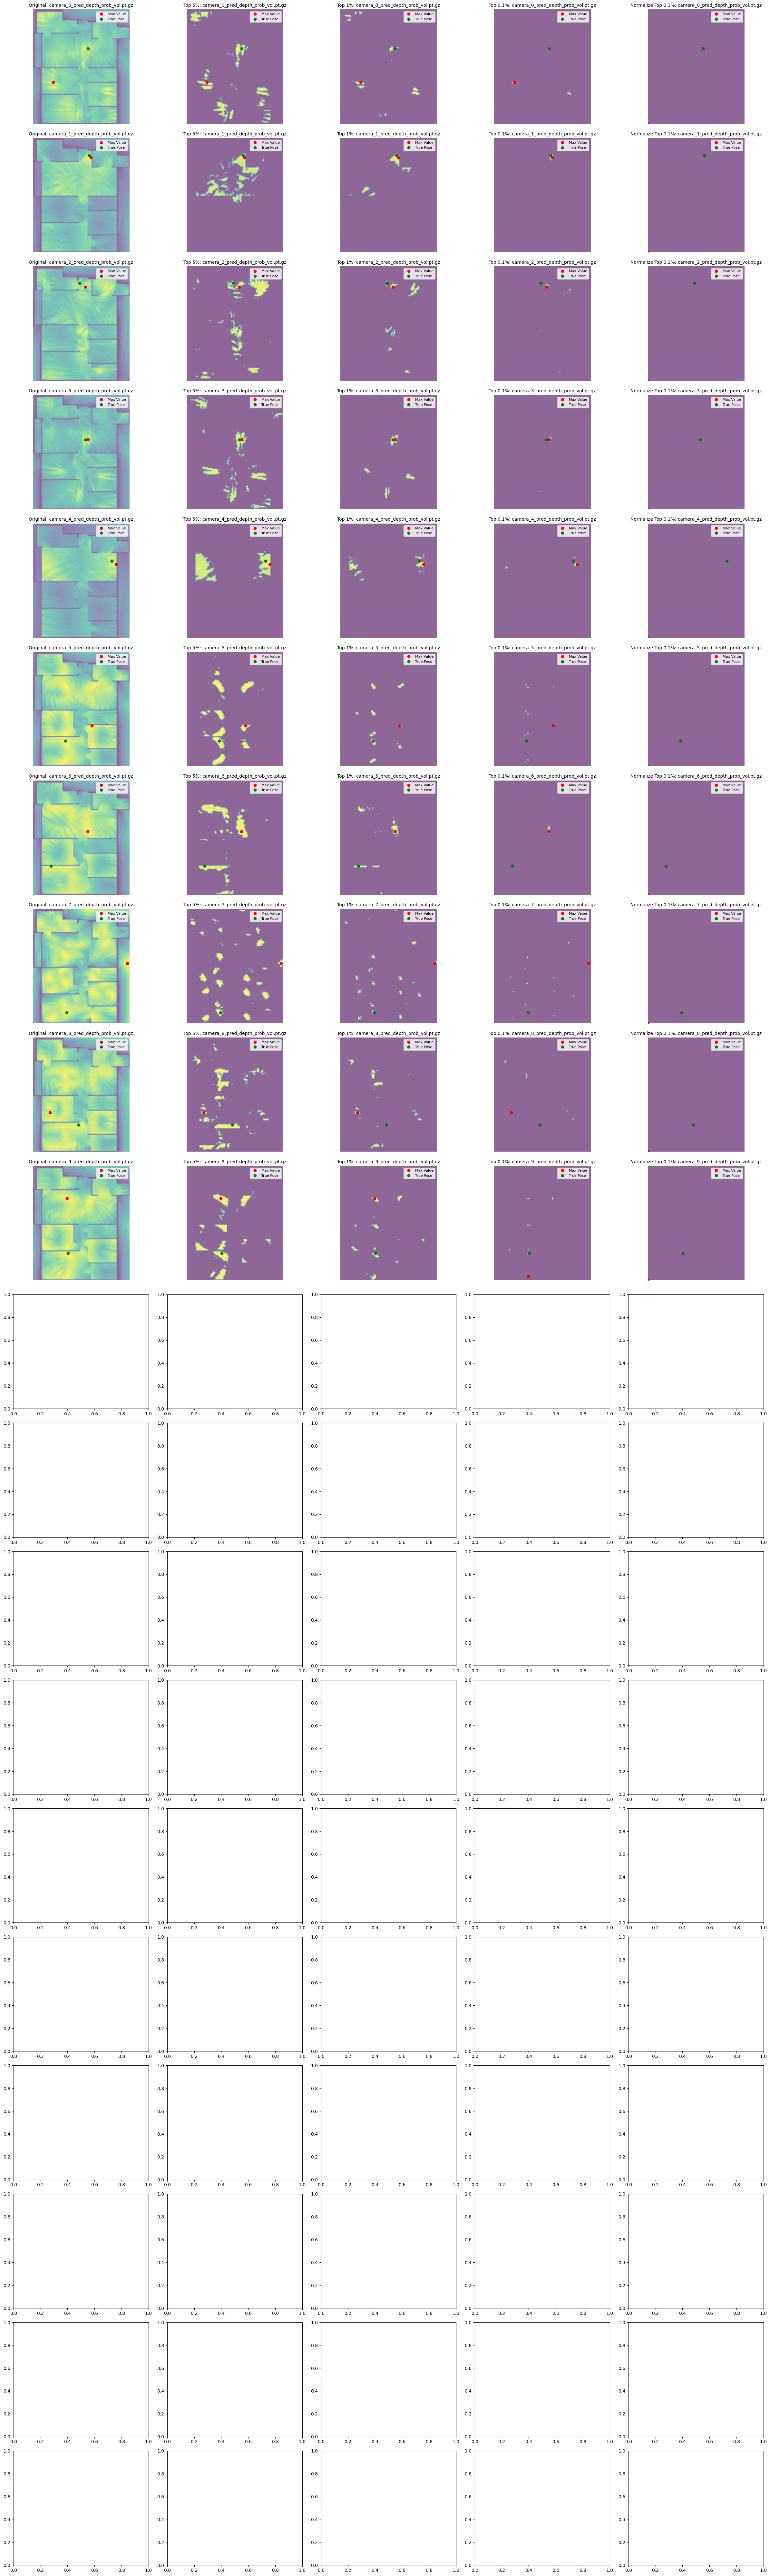

In [1]:
import torch
import gzip
import os
import numpy as np
import matplotlib.pyplot as plt
import re
import cv2

# Method to extract camera number from file name
def extract_camera_number(file_name):
    match = re.search(r'\d+', file_name)  # Find the first number in the file name
    if match:
        return int(match.group())  # Convert the matched number to an integer
    return float('inf')  # If no number is found, assign a very high number (or handle differently)

# Function to load a compressed tensor
def load_compressed_tensor(file_path):
    with gzip.open(file_path, 'rb') as f:
        tensor = torch.load(f)
    return tensor

# Function to read poses from a file
def read_poses(file_path):
    poses = []
    with open(file_path, 'r') as f:
        for line in f:
            x, y, _ = map(float, line.strip().split())
            poses.append((x, y))
    return poses

# Function to plot a single map using the provided method
def plot_single_map(prob_map, occ, true_pose, H, W, resolution, title, ax):
    prob_map = prob_map.astype(np.float32)
    prob_map = np.flipud(cv2.resize(prob_map, (prob_map.shape[1]*10, prob_map.shape[0]*10), interpolation=cv2.INTER_LINEAR))
    H = prob_map.shape[0]
    W = prob_map.shape[1]
    ax.imshow(prob_map, extent=[0, W, 0, H], cmap='viridis', alpha=0.6, origin='lower')

    # Add a red dot at the maximum of the map
    max_y, max_x = np.unravel_index(np.argmax(prob_map), prob_map.shape)
    ax.plot(max_x, (max_y), 'ro', label='Max Value')

    # Add a green dot for the true pose
    if true_pose:
        true_pose_x = true_pose[0] * (1 / resolution) * 10
        true_pose_y = H - true_pose[1] * (1 / resolution) * 10
        ax.plot(true_pose_x, true_pose_y, 'go', label='True Pose')

    ax.set_title(title, fontsize=10)
    ax.axis('off')
    ax.legend(fontsize=8)

scene_num = 3252
scene_dir = f"/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/prob_vols/scene_{scene_num}"
poses_file = f"/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full/scene_{scene_num}/poses.txt"

# Read poses from file
poses = read_poses(poses_file)

# Collect all heatmaps
heatmaps = []

for file_name in os.listdir(scene_dir):
    if file_name.endswith("pred_depth_prob_vol.pt.gz"):  # Filter for depth_prob_vol files
        file_path = os.path.join(scene_dir, file_name)
        # Load the tensor
        prob_vol = load_compressed_tensor(file_path)
        # Take the max over the O dimension (dim=2)
        heatmap = prob_vol.max(dim=2).values.numpy()
        # Compute the 95th percentile threshold
        threshold_0_1 = np.percentile(heatmap, 99.9)
        threshold_1 = np.percentile(heatmap, 99)
        threshold_5 = np.percentile(heatmap, 95)
        # Mask values below the threshold
        top_95_mask = heatmap >= threshold_5
        # Normalize only the top 95% values
        top_95_values = heatmap[top_95_mask]
        
        softmax_heatmap = np.zeros_like(heatmap)
        softmax_heatmap[top_95_mask] = np.exp(top_95_values)
        softmax_heatmap[top_95_mask] /= np.sum(np.exp(top_95_values))  # Normalize to sum to 1
        
        # Sampling from the softmax map
        flat_indices = np.arange(heatmap.size)
        sampled_index = np.random.choice(flat_indices, p=softmax_heatmap.ravel())
        sampled_y, sampled_x = np.unravel_index(sampled_index, heatmap.shape)
        
        # Top maps for visualization
        top_0_1_map = np.where(heatmap >= threshold_0_1, heatmap, heatmap * 0)
        top_1_map = np.where(heatmap >= threshold_1, heatmap, heatmap * 0)
        top_5_map = np.where(heatmap >= threshold_5, heatmap, heatmap * 0)

        # Append all maps and sampled indices
        heatmaps.append((file_name, heatmap, top_1_map, top_5_map, top_0_1_map, (sampled_x, sampled_y)))

# Sort heatmaps by camera number
heatmaps.sort(key=lambda x: extract_camera_number(x[0]))
heatmaps =heatmaps[:10]
# Plot heatmaps in a grid
resolution = 0.1  # Example resolution, adjust as needed
H, W = heatmaps[0][1].shape  # Assuming all heatmaps have the same shape

# Adjust the number of rows in the figure to accommodate GT rows
fig, axes = plt.subplots(len(heatmaps) * 2, 5, figsize=(24, len(heatmaps) * 8))

for i, (file_name, heatmap, top_1_map, top_5_map, top_0_1_map, sampled_pose) in enumerate(heatmaps):
    true_pose = poses[i] if i < len(poses) else None  # Match pose to the heatmap if available

    # Compute the softmax map for top 0.1% values for predicted heatmap
    top_0_1_softmax = np.zeros_like(heatmap)
    top_0_1_mask = heatmap >= threshold_0_1
    top_0_1_values = heatmap[top_0_1_mask]
    if top_0_1_values.size > 0:  # Ensure there are values to process
        # top_0_1_softmax[top_0_1_mask] = np.exp(top_0_1_values)
        top_0_1_softmax[top_0_1_mask] /= np.sum(np.exp(top_0_1_values))

    # Load and process GT heatmap
    gt_file_name = file_name.replace("pred_depth_prob_vol.pt.gz", "gt_depth_prob_vol.pt.gz")
    gt_file_path = os.path.join(scene_dir, gt_file_name)
    if os.path.exists(gt_file_path):
        gt_prob_vol = load_compressed_tensor(gt_file_path)
        gt_heatmap = gt_prob_vol.max(dim=2).values.numpy()

        # Compute thresholds for GT similar to prediction
        gt_threshold_0_1 = np.percentile(gt_heatmap, 99.9)

        # Compute the softmax map for top 0.1% values for GT heatmap
        gt_top_0_1_softmax = np.zeros_like(gt_heatmap)
        gt_top_0_1_mask = gt_heatmap >= gt_threshold_0_1
        gt_top_0_1_values = gt_heatmap[gt_top_0_1_mask]
        if gt_top_0_1_values.size > 0:
            gt_top_0_1_softmax[gt_top_0_1_mask] = np.exp(gt_top_0_1_values)
            gt_top_0_1_softmax[gt_top_0_1_mask] /= np.sum(np.exp(gt_top_0_1_values))
    else:
        print(f"GT file not found for {file_name}")

    # Plotting Predicted and GT maps
    plot_single_map(heatmap, None, true_pose, H, W, resolution, f"Original: {file_name}", axes[i, 0])
    plot_single_map(top_5_map, None, true_pose, H, W, resolution, f"Top 5%: {file_name}", axes[i, 1])
    plot_single_map(top_1_map, None, true_pose, H, W, resolution, f"Top 1%: {file_name}", axes[i, 2])
    plot_single_map(top_0_1_map, None, true_pose, H, W, resolution, f"Top 0.1%: {file_name}", axes[i, 3])
    plot_single_map(top_0_1_softmax, None, true_pose, H, W, resolution, f"Normalize Top 0.1%: {file_name}", axes[i, 4])


plt.tight_layout()
plt.show()


In [ ]:
import os
from PIL import Image

# Define the directory path
base_dir = '/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full/'

# Initialize lists to store dimensions
heights = []
widths = []
areas = []

# Count the total number of scenes before filtering
initial_count = 0
filtered_count = 0

# Walk through the directory and process the images
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('floorplan_semantic.png'):
            # Get the full path to the image
            file_path = os.path.join(root, file)
            # Open the image
            with Image.open(file_path) as img:
                width, height = img.size
                initial_count += 1

                if width <= 1800 and height <= 1800:
                    widths.append(width)
                    heights.append(height)
                    areas.append(width * height)
                    filtered_count += 1

# Print the counts before and after filtering
removed_count = initial_count - filtered_count
print(f"Total number of scenes before filtering: {initial_count}")
print(f"Total number of scenes after filtering: {filtered_count}")
print(f"Number of scenes removed: {removed_count}")


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Define the directory path
base_dir = '/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full/'
# Initialize lists to store dimensions
heights = []
widths = []
areas = []

# Walk through the directory and process the images
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith('floorplan_semantic.png'):
            # Get the full path to the image
            file_path = os.path.join(root, file)
            # Open the image
            with Image.open(file_path) as img:
                width, height = img.size
                heights.append(height)
                widths.append(width)
                areas.append(width * height)

# Count occurrences of each height and width
height_counter = Counter(heights)
width_counter = Counter(widths)

# Plot area distribution
plt.figure(figsize=(12, 6))
plt.hist(heights, bins=50, color='lightcoral')
plt.title('Distribution of H')
plt.xlabel('H')
plt.ylabel('Frequency')
plt.show()

# Plot area distribution
plt.figure(figsize=(12, 6))
plt.hist(widths, bins=50, color='lightcoral')
plt.title('Distribution W')
plt.xlabel('W')
plt.ylabel('Frequency')
plt.show()

# Plot area distribution
plt.figure(figsize=(12, 6))
plt.hist(areas, bins=50, color='lightcoral')
plt.title('Distribution of Image Areas')
plt.xlabel('Area (pixels^2)')
plt.ylabel('Frequency')
plt.show()


In [ ]:
# import torch
# from utils.visualization_utils import plot_prob_dist
# import os
# import cv2
# import gzip

# # Example parameters for plotting
# resolution = 0.1  # Example resolution value
# scene_name = "scene_3250"
# camera_number = 1
# type_pred = 'gt' #gt/pred
# source = "depth" #semantic/depth
# dataset_dir ="/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full"
# save_path = '/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/results/full/diffusion/Prob_vol_db_plots'  # Path to save the visualizations
# file_name = f'{scene_name}_camera_{camera_number}_{type_pred}_{source}_visualization'
# occ = cv2.imread(os.path.join(dataset_dir, scene_name, "floorplan_semantic.png"))
# pose_pred = torch.tensor([0, 0, 0], dtype=torch.float32)  # Example pose, replace with actual if available
# ref_pose_map = torch.tensor([0, 0, 0], dtype=torch.float32)  # Example reference pose

# # Load the probability volume from the specified path
# prob_vol_path = f'/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/prob_vols/{scene_name}/camera_{camera_number}_{type_pred}_{source}_prob_vol.pt.gz'
# with gzip.open(prob_vol_path, 'rb') as f_in:
#     prob_vol_data, _ = torch.max(torch.load(f_in, weights_only=True).float(), dim=2)  # [H, W]
# # Plot the probability distribution
# plot_prob_dist(
#     prob_dist=prob_vol_data,
#     resolution=resolution,
#     save_path=save_path,
#     file_name=file_name,
#     occ=occ,
#     pose_pred=pose_pred,
#     ref_pose_map=ref_pose_map,
#     plot_type="combined",
#     acc=0,  # Replace with actual accuracy if calculated
#     acc_orn=0,  # Replace with actual orientation accuracy if calculated
#     acc_only=False  # Set to True if plotting accuracy only
# )

# print(f"Plot saved to {os.path.join(save_path, file_name)}")


In [ ]:
import os

# Define the directory path
base_path = "/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/prob_vols"

# Define the range of scene numbers to check
min_scene_num = 1
max_scene_num = 3500

# Generate the full set of expected scene names (e.g., scene_1, scene_2, ..., scene_3500)
expected_scenes = {f"scene_{i}" for i in range(min_scene_num, max_scene_num + 1)}

# List actual folders in the base path
actual_scenes = set(folder_name for folder_name in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, folder_name)))

# Identify missing scenes by comparing expected and actual sets
missing_scenes = expected_scenes - actual_scenes

# Print the count and names of missing scenes
print(f"Total missing scenes: {len(missing_scenes)}")
print("Missing scene names:")
l=[]
for scene in sorted(missing_scenes):
    l.append(scene)
print(l)

In [ ]:
import os
from PIL import Image

# Directory path containing the scene folders
base_dir = '/datadrive2/CRM.AI.Research/TeamFolders/Email/repo_yuval/FloorPlan/Semantic_Floor_plan_localization/data/test_data_set_full/structured3d_perspective_full'

# Pixel threshold for size difference
pixel_threshold = 5

# List to store the names of scenes with differing image sizes
mismatched_scenes = []

# Iterate over the scene directories
for scene_name in os.listdir(base_dir):
    scene_path = os.path.join(base_dir, scene_name)
    semantic_path = os.path.join(scene_path, 'floorplan_semantic.png')
    walls_only_path = os.path.join(scene_path, 'floorplan_walls_only.png')
    
    # Check if both images exist
    if os.path.isfile(semantic_path) and os.path.isfile(walls_only_path):
        with Image.open(semantic_path) as img_semantic, Image.open(walls_only_path) as img_walls:
            # Get image sizes
            width_semantic, height_semantic = img_semantic.size
            width_walls, height_walls = img_walls.size
            
            # Calculate absolute differences
            width_diff = abs(width_semantic - width_walls)
            height_diff = abs(height_semantic - height_walls)
            
            # Check if differences exceed the threshold
            if width_diff > pixel_threshold or height_diff > pixel_threshold:
                mismatched_scenes.append(scene_name)
mismatched_scenes.sort()

# Print the scenes with mismatched image sizes
print("Scenes with image size mismatches:", mismatched_scenes)


mismatched_scenes.sort()


In [ ]:
mismatched_scenes.sort()
print("Scenes with image size mismatches:", mismatched_scenes)
print(len(mismatched_scenes))
l = []
for s in mismatched_scenes:
    num = s.split("_")[1]
    num_s = str(num).zfill(5)
    name = "scene_" + num_s
    l.append(name)
print(l)